# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

In [21]:
import random

# --- Card class ---
class Card:
    def __init__(self, rank, suit, value):
        self.rank = rank
        self.suit = suit
        self.value = value

    def __str__(self):
        return f"{self.rank} of {self.suit}"


# --- Deck class ---
class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.plastic_card_index = None
        self.reset_deck()

    def reset_deck(self):
        self.cards = []
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks_values = [
            ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6),
            ('7', 7), ('8', 8), ('9', 9), ('10', 10),
            ('J', 10), ('Q', 10), ('K', 10), ('A', 11)
        ]
        for _ in range(self.num_decks):
            for suit in suits:
                for rank, value in ranks_values:
                    self.cards.append(Card(rank, suit, value))
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.cards)
        self.plastic_card_index = random.randint(int(len(self.cards) * 0.75), len(self.cards) - 1)

    def draw_card(self):
        if len(self.cards) == 0:
            self.reset_deck()
        return self.cards.pop(0)

    def is_plastic_card_dealt(self):
        return len(self.cards) <= self.plastic_card_index


# --- Hand class ---
class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def get_value(self):
        total = 0
        aces = 0
        for card in self.cards:
            total += card.value
            if card.rank == 'A':
                aces += 1
        while total > 21 and aces:
            total -= 10
            aces -= 1
        return total

    def is_blackjack(self):
        return len(self.cards) == 2 and self.get_value() == 21

    def is_bust(self):
        return self.get_value() > 21


# --- Strategy base class ---
class Strategy:
    def decide_hit(self, hand, visible_cards, count):
        raise NotImplementedError("This should be implemented by subclasses.")


# --- Card Counting Strategy ---
class CardCountingStrategy(Strategy):
    def __init__(self, threshold=0):
        self.count = 0
        self.threshold = threshold

    def update_count(self, card):
        if 2 <= card.value <= 6:
            self.count += 1
        elif card.value >= 10 or card.rank == 'A':
            self.count -= 1

    def decide_hit(self, hand, visible_cards, count=None):
        if count is not None:
            self.count = count
        return self.count <= self.threshold


# --- Player class ---
class Player:
    def __init__(self, name, strategy=None, chips=1000):
        self.name = name
        self.hand = Hand()
        self.chips = chips
        self.strategy = strategy

    def place_bet(self):
        return 10  # Simplified for now

    def play_turn(self, deck, visible_cards, count=0):
        while not self.hand.is_bust() and self.strategy and self.strategy.decide_hit(self.hand, visible_cards, count):
            card = deck.draw_card()
            self.hand.add_card(card)
            visible_cards.append(card)
            if isinstance(self.strategy, CardCountingStrategy):
                self.strategy.update_count(card)

    def reset_hand(self):
        self.hand = Hand()


# --- Dealer class ---
class Dealer(Player):
    def __init__(self):
        super().__init__(name="Dealer", strategy=None)

    def play_turn(self, deck, visible_cards, count=0):
        while self.hand.get_value() < 17:
            card = deck.draw_card()
            self.hand.add_card(card)
            visible_cards.append(card)


# --- Game class ---
class Game:
    def __init__(self, players, num_decks=6):
        self.deck = Deck(num_decks)
        self.players = players
        self.dealer = Dealer()
        self.round = 0

    def deal_initial_cards(self):
        for player in self.players:
            player.reset_hand()
            player.hand.add_card(self.deck.draw_card())
            player.hand.add_card(self.deck.draw_card())
        self.dealer.reset_hand()
        self.dealer.hand.add_card(self.deck.draw_card())
        self.dealer.hand.add_card(self.deck.draw_card())

    def play_round(self):
        self.round += 1
        self.deal_initial_cards()

        visible_cards = []
        # All cards visible except dealer's hidden one
        for player in self.players:
            visible_cards.extend(player.hand.cards)
        visible_cards.append(self.dealer.hand.cards[0])

        count = 0
        for card in visible_cards:
            if 2 <= card.value <= 6:
                count += 1
            elif card.value >= 10 or card.rank == 'A':
                count -= 1

        for player in self.players:
            player.play_turn(self.deck, visible_cards, count)

        self.dealer.play_turn(self.deck, visible_cards, count)
        self.evaluate_round()

        if self.deck.is_plastic_card_dealt():
            self.deck.reset_deck()

    def evaluate_round(self):
        dealer_value = self.dealer.hand.get_value()
        for player in self.players:
            player_value = player.hand.get_value()
            bet = player.place_bet()
            if player.hand.is_bust():
                player.chips -= bet
            elif self.dealer.hand.is_bust() or player_value > dealer_value:
                player.chips += bet
            elif player_value < dealer_value:
                player.chips -= bet
            # else: push (no change)

    def run_simulation(self, num_rounds=50):
        for _ in range(num_rounds):
            self.play_round()

In [22]:
# Create players
strategy_player = Player("Counter", strategy=CardCountingStrategy(threshold=0), chips=1000)
bot1 = Player("Bot1", strategy=CardCountingStrategy(threshold=0), chips=1000)
bot2 = Player("Bot2", strategy=CardCountingStrategy(threshold=0), chips=1000)
bot3 = Player("Bot3", strategy=CardCountingStrategy(threshold=0), chips=1000)

# Add all players to the game
players = [strategy_player, bot1, bot2, bot3]

# Create and run game
game = Game(players)
game.run_simulation(num_rounds=10)  # You can increase this to 50 or 100


In [23]:
for player in players:
    print(f"{player.name} has {player.chips} chips after simulation.")


Counter has 920 chips after simulation.
Bot1 has 920 chips after simulation.
Bot2 has 940 chips after simulation.
Bot3 has 920 chips after simulation.


Average chips after 50 rounds: 659.20
Standard deviation: 40.74
Probability of net gain: 0.00%
Probability of net loss: 100.00%


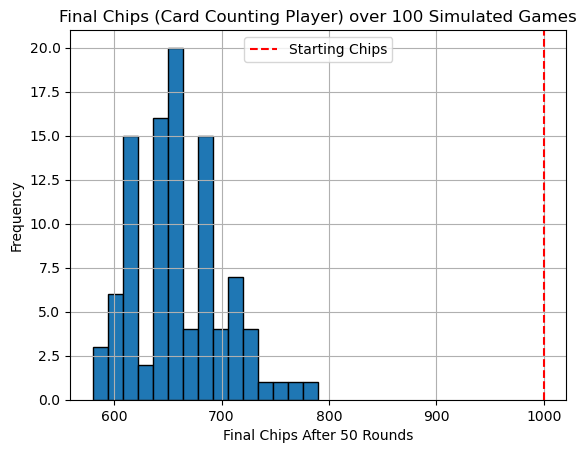


Threshold Scan Results:
Running threshold = -5
Running threshold = -3
Running threshold = -1
Running threshold = 0
Running threshold = 1
Running threshold = 2
Threshold -5: Average Final Chips = 887.70
Threshold -3: Average Final Chips = 827.30
Threshold -1: Average Final Chips = 715.60
Threshold 0: Average Final Chips = 646.80
Threshold 1: Average Final Chips = 599.10
Threshold 2: Average Final Chips = 565.20


In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np

# --- Card class ---
class Card:
    def __init__(self, rank, suit, value):
        self.rank = rank
        self.suit = suit
        self.value = value

    def __str__(self):
        return f"{self.rank} of {self.suit}"

# --- Deck class ---
class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.plastic_card_index = None
        self.reset_deck()

    def reset_deck(self):
        self.cards = []
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks_values = [
            ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6),
            ('7', 7), ('8', 8), ('9', 9), ('10', 10),
            ('J', 10), ('Q', 10), ('K', 10), ('A', 11)
        ]
        for _ in range(self.num_decks):
            for suit in suits:
                for rank, value in ranks_values:
                    self.cards.append(Card(rank, suit, value))
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.cards)
        self.plastic_card_index = random.randint(int(len(self.cards) * 0.75), len(self.cards) - 1)

    def draw_card(self):
        if len(self.cards) == 0:
            self.reset_deck()
        return self.cards.pop(0)

    def is_plastic_card_dealt(self):
        return len(self.cards) <= self.plastic_card_index

# --- Hand class ---
class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def get_value(self):
        total = 0
        aces = 0
        for card in self.cards:
            total += card.value
            if card.rank == 'A':
                aces += 1
        while total > 21 and aces:
            total -= 10
            aces -= 1
        return total

    def is_blackjack(self):
        return len(self.cards) == 2 and self.get_value() == 21

    def is_bust(self):
        return self.get_value() > 21

# --- Strategy base class ---
class Strategy:
    def decide_hit(self, hand, visible_cards, count):
        raise NotImplementedError("This should be implemented by subclasses.")

# --- Card Counting Strategy ---
class CardCountingStrategy(Strategy):
    def __init__(self, threshold=0):
        self.count = 0
        self.threshold = threshold

    def update_count(self, card):
        if 2 <= card.value <= 6:
            self.count += 1
        elif card.value >= 10 or card.rank == 'A':
            self.count -= 1

    def decide_hit(self, hand, visible_cards, count=None):
        if count is not None:
            self.count = count
        return self.count <= self.threshold

# --- Player class ---
class Player:
    def __init__(self, name, strategy=None, chips=1000):
        self.name = name
        self.hand = Hand()
        self.chips = chips
        self.strategy = strategy

    def place_bet(self):
        return 10  # Simplified for now

    def play_turn(self, deck, visible_cards, count=0):
        while not self.hand.is_bust() and self.strategy and self.strategy.decide_hit(self.hand, visible_cards, count):
            card = deck.draw_card()
            self.hand.add_card(card)
            visible_cards.append(card)
            if isinstance(self.strategy, CardCountingStrategy):
                self.strategy.update_count(card)

    def reset_hand(self):
        self.hand = Hand()

# --- Dealer class ---
class Dealer(Player):
    def __init__(self):
        super().__init__(name="Dealer", strategy=None)

    def play_turn(self, deck, visible_cards, count=0):
        while self.hand.get_value() < 17:
            card = deck.draw_card()
            self.hand.add_card(card)
            visible_cards.append(card)

# --- Game class ---
class Game:
    def __init__(self, players, num_decks=6):
        self.deck = Deck(num_decks)
        self.players = players
        self.dealer = Dealer()
        self.round = 0

    def deal_initial_cards(self):
        for player in self.players:
            player.reset_hand()
            player.hand.add_card(self.deck.draw_card())
            player.hand.add_card(self.deck.draw_card())
        self.dealer.reset_hand()
        self.dealer.hand.add_card(self.deck.draw_card())
        self.dealer.hand.add_card(self.deck.draw_card())

    def play_round(self):
        self.round += 1
        self.deal_initial_cards()

        visible_cards = []
        for player in self.players:
            visible_cards.extend(player.hand.cards)
        visible_cards.append(self.dealer.hand.cards[0])

        count = 0
        for card in visible_cards:
            if 2 <= card.value <= 6:
                count += 1
            elif card.value >= 10 or card.rank == 'A':
                count -= 1

        for player in self.players:
            player.play_turn(self.deck, visible_cards, count)

        self.dealer.play_turn(self.deck, visible_cards, count)
        self.evaluate_round()

        if self.deck.is_plastic_card_dealt():
            self.deck.reset_deck()

    def evaluate_round(self):
        dealer_value = self.dealer.hand.get_value()
        for player in self.players:
            player_value = player.hand.get_value()
            bet = player.place_bet()
            if player.hand.is_bust():
                player.chips -= bet
            elif self.dealer.hand.is_bust() or player_value > dealer_value:
                player.chips += bet
            elif player_value < dealer_value:
                player.chips -= bet
            # else: push (no chip change)

    def run_simulation(self, num_rounds=50):
        for _ in range(num_rounds):
            self.play_round()

# --- Simulation Function ---
def simulate_strategy(threshold=0, num_games=100, rounds_per_game=50, starting_chips=1000):
    final_chip_counts = []

    for _ in range(num_games):
        strategy = CardCountingStrategy(threshold=threshold)
        strategy_player = Player("Counter", strategy=strategy, chips=starting_chips)
        bots = [Player(f"Bot{i+1}", strategy=CardCountingStrategy(threshold=0), chips=starting_chips)
                for i in range(3)]

        game = Game(players=[strategy_player] + bots)
        game.run_simulation(rounds_per_game)

        final_chip_counts.append(strategy_player.chips)

    return final_chip_counts

# --- Run Simulation ---
chip_counts = simulate_strategy(threshold=0)

# --- Analysis ---
chips_array = np.array(chip_counts)
mean = np.mean(chips_array)
std_dev = np.std(chips_array)
prob_gain = np.sum(chips_array > 1000) / len(chips_array)
prob_loss = np.sum(chips_array < 1000) / len(chips_array)

print(f"Average chips after 50 rounds: {mean:.2f}")
print(f"Standard deviation: {std_dev:.2f}")
print(f"Probability of net gain: {prob_gain:.2%}")
print(f"Probability of net loss: {prob_loss:.2%}")

# --- Histogram Plot ---
plt.hist(chips_array, bins=15, edgecolor='black')
plt.title("Final Chips (Card Counting Player) over 100 Simulated Games")
plt.xlabel("Final Chips After 50 Rounds")
plt.ylabel("Frequency")
plt.axvline(1000, color='red', linestyle='dashed', label='Starting Chips')
plt.legend()
plt.grid(True)
plt.show()

# --- Threshold Scan ---
thresholds = [-5, -3, -1, 0, 1, 2]
results = {}

print("\nThreshold Scan Results:")
for t in thresholds:
    print(f"Running threshold = {t}")
    chips = simulate_strategy(threshold=t)
    avg = np.mean(chips)
    results[t] = avg

for t in thresholds:
    print(f"Threshold {t}: Average Final Chips = {results[t]:.2f}")
